✅ Loaded dataset from: /content/Mall_Customers.csv

📄 Dataset preview:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


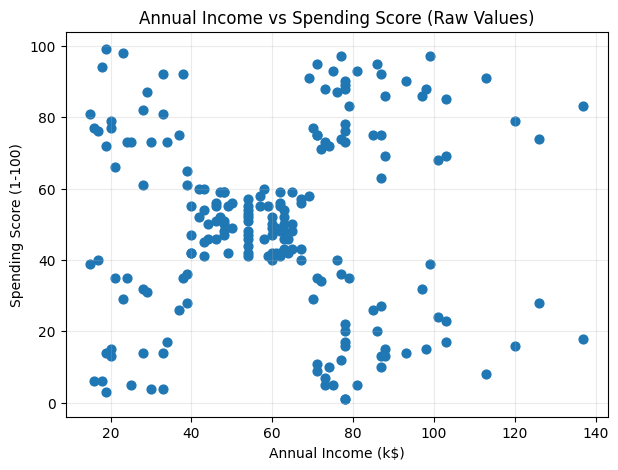

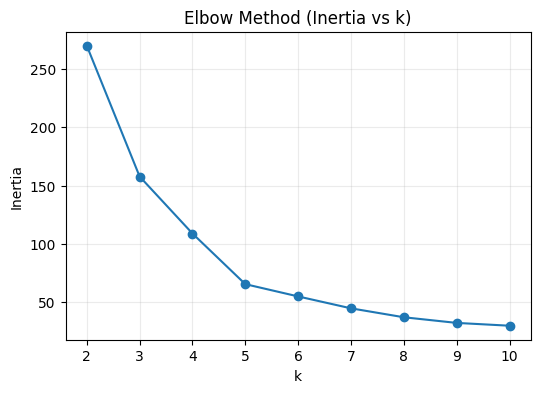

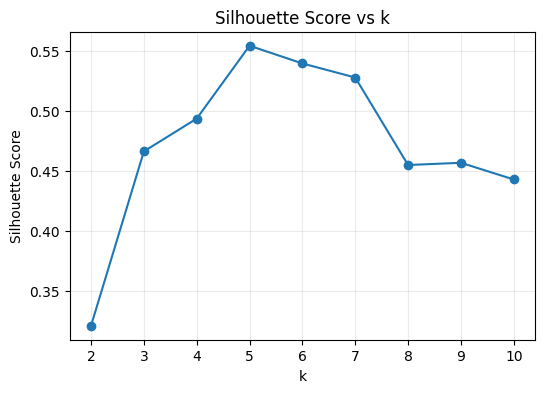

🏆 Suggested best k by silhouette: 5 (score=0.555)


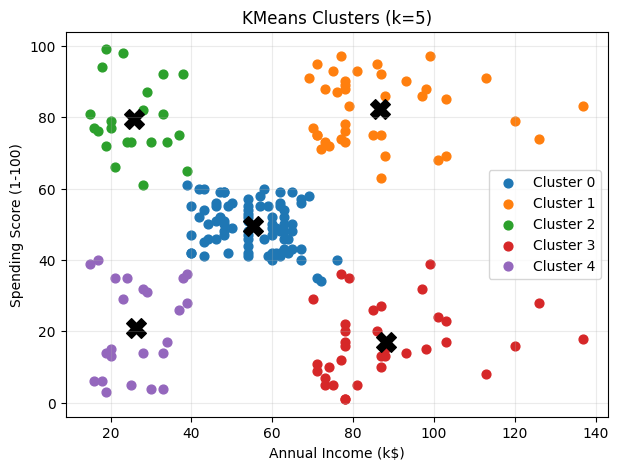


📊 KMeans cluster summary:


,kmeans_cluster,size,avg_income_k,avg_spending,avg_age
0,0,81,55.296296,49.518519,42.716049
1,1,39,86.538462,82.128205,32.692308
2,2,22,25.727273,79.363636,25.272727
3,3,35,88.200000,17.114286,41.114286
4,4,23,26.304348,20.913043,45.217391



📊 DBSCAN cluster summary (label -1 = noise):


,dbscan_cluster,size,avg_income,avg_spending
0,-1,5,129.2,43.800000
1,0,195,58.8,50.364103


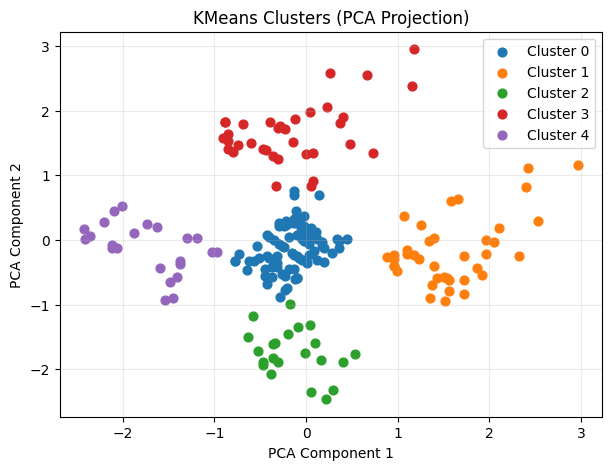

In [1]:
# Customer Segmentation: Mall Customers (Annual Income vs Spending Score)
# Works directly in Google Colab — expects /content/Mall_Customers.csv
# If not found, it automatically generates a synthetic dataset.

# --- Setup ---
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

# --- 1) Load dataset ---
path = "/content/Mall_Customers.csv"

if os.path.exists(path):
    df = pd.read_csv(path)
    print(f"✅ Loaded dataset from: {path}")
else:
    print("⚠️ Mall_Customers.csv not found in /content/. Creating a synthetic dataset instead.")
    np.random.seed(42)
    n = 200
    genders = np.random.choice(['Male', 'Female'], size=n)
    ages = np.random.randint(18, 70, size=n)

    income_low = np.random.normal(25, 6, 60)
    income_mid = np.random.normal(55, 8, 80)
    income_high = np.random.normal(90, 7, 60)
    income = np.concatenate([income_low, income_mid, income_high])
    np.random.shuffle(income)

    spending = np.concatenate([
        np.random.normal(70, 10, 60),
        np.random.normal(40, 12, 80),
        np.random.normal(20, 8, 60)
    ])
    spending = np.clip(spending, 1, 99)
    np.random.shuffle(spending)

    df = pd.DataFrame({
        'CustomerID': np.arange(1, n+1),
        'Gender': genders,
        'Age': ages,
        'Annual Income (k$)': np.round(income, 1),
        'Spending Score (1-100)': np.round(spending, 1)
    })

print("\n📄 Dataset preview:")
display(df.head())

# --- 2) Select features and scale ---
features = ['Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3) Visual exploration ---
plt.figure(figsize=(7,5))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], s=40)
plt.title("Annual Income vs Spending Score (Raw Values)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.grid(alpha=0.25)
plt.show()

# --- 4) Find optimal k (Elbow + Silhouette) ---
ks = range(2, 11)
inertias, sil_scores = [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method (Inertia vs k)")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.grid(alpha=0.25)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Score vs k")
plt.xlabel("k"); plt.ylabel("Silhouette Score"); plt.grid(alpha=0.25)
plt.show()

best_k = ks[np.argmax(sil_scores)]
print(f"🏆 Suggested best k by silhouette: {best_k} (score={max(sil_scores):.3f})")

# --- 5) Fit KMeans & visualize ---
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_km = kmeans.fit_predict(X_scaled)
centers_orig = scaler.inverse_transform(kmeans.cluster_centers_)

plt.figure(figsize=(7,5))
for c in np.unique(labels_km):
    mask = labels_km == c
    plt.scatter(X[mask,0], X[mask,1], s=40, label=f"Cluster {c}")
plt.scatter(centers_orig[:,0], centers_orig[:,1], s=200, marker='X', color='black')
plt.title(f"KMeans Clusters (k={best_k})")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend(); plt.grid(alpha=0.25)
plt.show()

# --- 6) Cluster summary ---
df_km = df.copy()
df_km['kmeans_cluster'] = labels_km
summary = df_km.groupby('kmeans_cluster').agg(
    size=('CustomerID','count'),
    avg_income_k=('Annual Income (k$)','mean'),
    avg_spending=('Spending Score (1-100)','mean'),
    avg_age=('Age','mean')
).reset_index()
print("\n📊 KMeans cluster summary:")
display(summary)

# --- 7) DBSCAN (bonus) ---
db = DBSCAN(eps=0.6, min_samples=5)
labels_db = db.fit_predict(X_scaled)
df_db = df.copy()
df_db['dbscan_cluster'] = labels_db
summary_db = df_db.groupby('dbscan_cluster').agg(
    size=('CustomerID','count'),
    avg_income=('Annual Income (k$)','mean'),
    avg_spending=('Spending Score (1-100)','mean')
).reset_index()
print("\n📊 DBSCAN cluster summary (label -1 = noise):")
display(summary_db)

# --- 8) Optional: PCA visualization ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
for c in np.unique(labels_km):
    mask = labels_km == c
    plt.scatter(X_pca[mask,0], X_pca[mask,1], s=40, label=f"Cluster {c}")
plt.title("KMeans Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(); plt.grid(alpha=0.25)
plt.show()
